# Analysis Scripts for RMP Data

In [1]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx

import numpy as np
import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt
import matplotlib as mpl

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real
from tqdm.notebook import tqdm

In [3]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
import c1lgkt.jax.fields.clebsch
from c1lgkt.jax.fields.clebsch import ClebschMappingBuilder, _objective_uv_params, _objective_uv_params_refine, ThetaMapping
from c1lgkt.jax.fields.field_providers import EikonalFieldProvider
import c1lgkt.jax.particles.particle_motion as particle_motion
import c1lgkt.jax.particles.particle_tools as particle_tools

In [4]:
# %% Load equilibrium and set up clebsch mapping
eq = Equilibrium.from_gfile('./tests/g204386.03600')

clebsch_builder = ClebschMappingBuilder()
theta_map = clebsch_builder.build_theta_map(eq)
clebsch = clebsch_builder.build_clebsch(theta_map, eq)

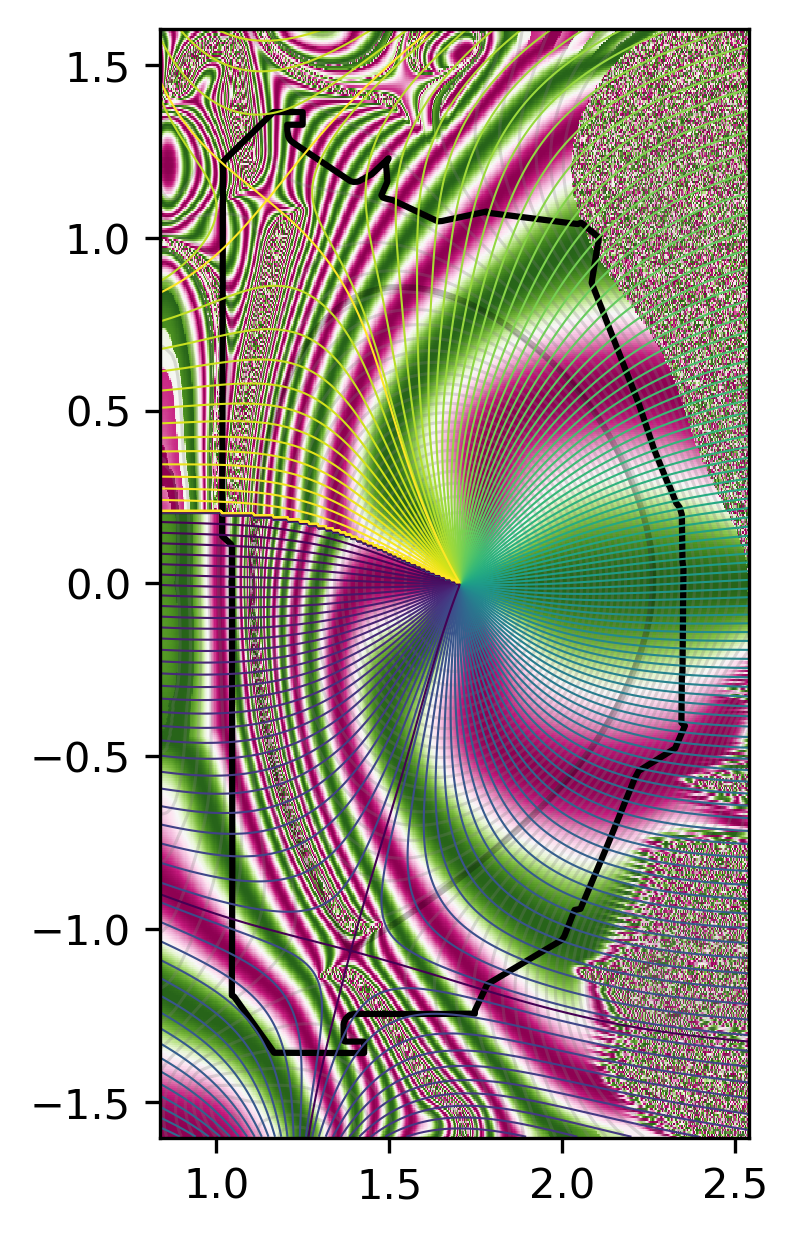

In [5]:
# %% Check the Clebsch variable
plt.figure(dpi=300)

rplot, zplot = jnp.meshgrid(jnp.linspace(eq.rmin, eq.rmax, 512), jnp.linspace(eq.zmin, eq.zmax, 512), indexing='ij')
psiplot = eq.interp_psi(rplot.ravel(), zplot.ravel()).reshape(rplot.shape)
#y0_refine_test = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], -1.0, 0.0, 0.0, 0.0])
nulls = theta_map.nulls
thetaplot2 = theta_map(rplot.ravel(), zplot.ravel()).reshape(rplot.shape)
theta_x = theta_map(jnp.array([nulls.x1.rz[0], nulls.x2.rz[0]]), jnp.array([nulls.x1.rz[1], nulls.x2.rz[1]]))

alphaplot = clebsch.interp_alpha(psiplot.ravel(), thetaplot2.ravel()).reshape(rplot.shape)

ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax, alpha=0.25)
ax.scatter(theta_map.nulls.axis.rz[0], theta_map.nulls.axis.rz[1], c='r', s=5)
ax.scatter(theta_map.nulls.x1.rz[0], theta_map.nulls.x1.rz[1], c='r', s=5)
ax.scatter(theta_map.nulls.x2.rz[0], theta_map.nulls.x2.rz[1], c='r', s=5)
#plt.contour(rplot, zplot, thetaplot, levels=jnp.linspace(-np.pi, np.pi, 129), linewidths=0.5, linestyles='dashed')
plt.contour(rplot, zplot, thetaplot2, levels=jnp.linspace(-np.pi, np.pi, 129), linewidths=0.5)
plt.contour(rplot, zplot, thetaplot2, levels=theta_x, linewidths=0.5)
plt.pcolormesh(rplot, zplot, jnp.cos(3*alphaplot), linewidths=0.5, cmap='PiYG')

In [23]:
# %% Load the RMP data
rmp_data = Dataset('./tests/204386_3600_512x12x512_response_data.nc', 'r')
#rmp_data = Dataset('./tests/204386_3600_response_data.nc', 'r')

rgrid = rmp_data['R'][:]
zgrid = rmp_data['Z'][:]

#print(rmp_data.variables)

# Compute FFTs of the RMP data (kind of)
keys = ['E_Er', 'E_Ez', 'E_Et', 'del_B_del_Br', 'del_B_del_Bz', 'del_B_del_Bt', 'del_phi', 'del_Apar']

rmp_data_fft = {
    key: np.fft.rfft(rmp_data[key][:,:,:], axis=1) for key in keys
}

print(rmp_data.variables)

{'R': <class 'netCDF4.Variable'>
float64 R(R)
unlimited dimensions: 
current shape = (512,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'PHI': <class 'netCDF4.Variable'>
float64 PHI(PHI)
unlimited dimensions: 
current shape = (12,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'Z': <class 'netCDF4.Variable'>
float64 Z(Z)
unlimited dimensions: 
current shape = (512,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'del_phi': <class 'netCDF4.Variable'>
float64 del_phi(R, PHI, Z)
unlimited dimensions: 
current shape = (512, 12, 512)
filling on, default _FillValue of 9.969209968386869e+36 used, 'del_Apar': <class 'netCDF4.Variable'>
float64 del_Apar(R, PHI, Z)
unlimited dimensions: 
current shape = (512, 12, 512)
filling on, default _FillValue of 9.969209968386869e+36 used, 'B_Br': <class 'netCDF4.Variable'>
float64 B_Br(R, PHI, Z)
unlimited dimensions: 
current shape = (512, 12, 512)
filling on, default _FillValue of 9.969209968386869e+36 us

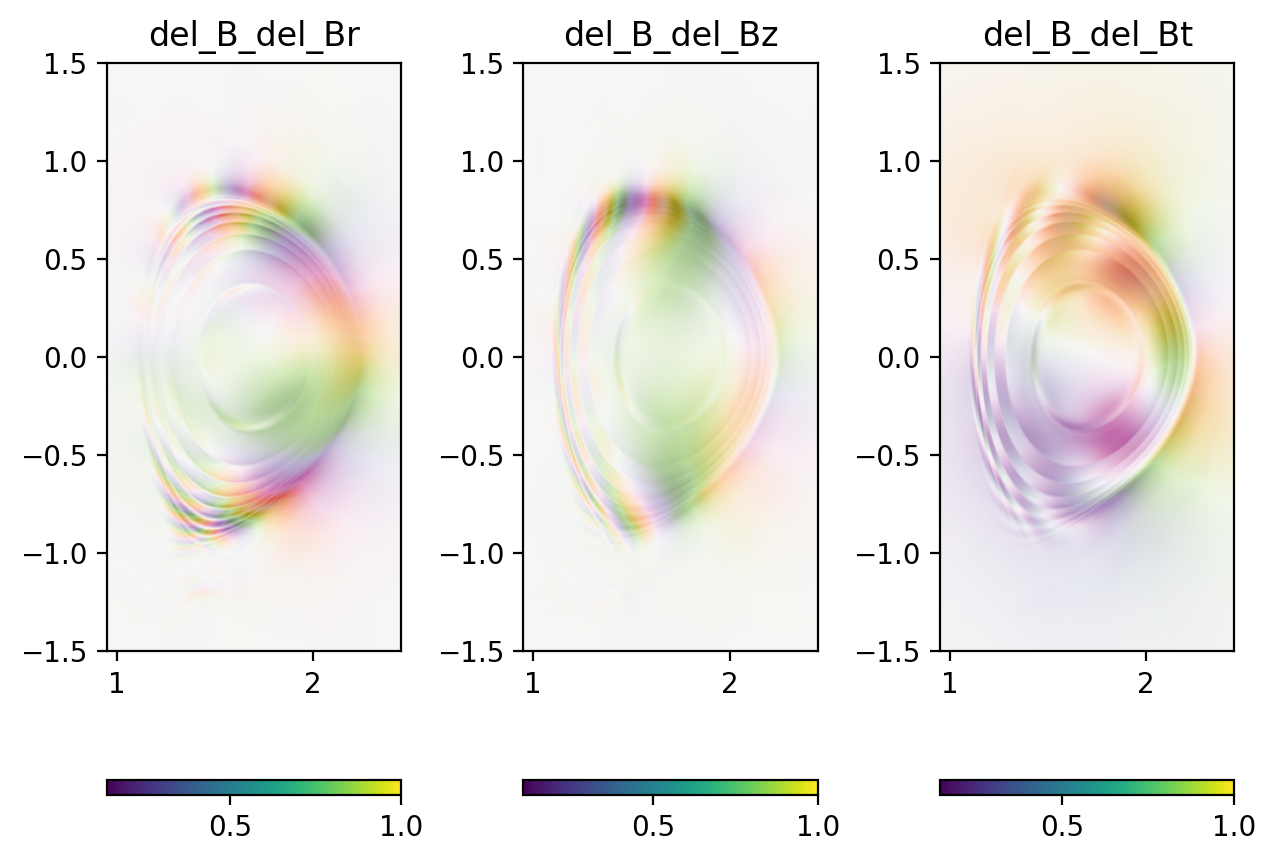

In [ ]:
# %% Plot the n=3 component of the RMP fields
plt.figure(dpi=200)

def reim_color(z):
    vmax = jnp.max(jnp.abs(z))
    norm = mpl.colors.CenteredNorm(halfrange=vmax)
    real_part = mpl.cm.PiYG(norm(jnp.real(z)))
    imag_part = mpl.cm.PuOr(norm(jnp.imag(z)))
    # Blend the real and imaginary parts together
    blended = (real_part + imag_part) / 2
    return blended


for i, key in enumerate(['del_B_del_Br', 'del_B_del_Bz', 'del_B_del_Bt']):
    ax = plt.subplot(1, 3, i+1)
    #eq.plot_magnetic_geometry(ax, alpha=0.25)
    ax.imshow(reim_color(rmp_data_fft[key][:,3,:].T), extent=(rgrid[0], rgrid[-1], zgrid[0], zgrid[-1]), origin='lower', aspect='equal')
    plt.colorbar(location='bottom')
    plt.title(key)
    #ax.set_aspect('equal')


plt.tight_layout()

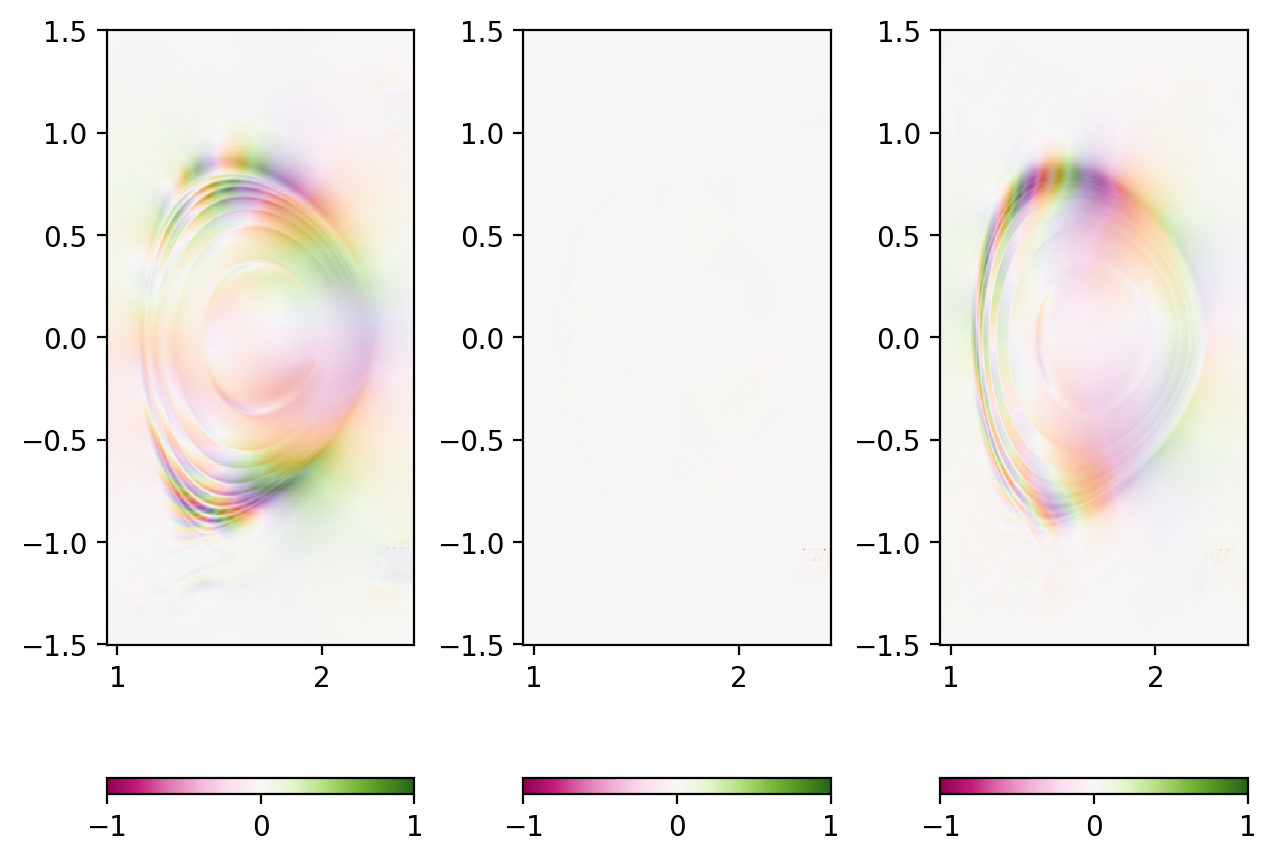

In [52]:

# %% Plot the n=3 component of the RMP fields computed from A_parallel
#plt.figure(dpi=300)

# Set up interpolator
apar = jnp.array(rmp_data_fft['del_Apar'][:,3,:])
interp_apar = interpax.Interpolator2D(rgrid.filled(), zgrid.filled(), apar, method='cubic')

# Compute the RMP fields from A_parallel
apar_flat = apar.flatten()
rplot, zplot = jnp.meshgrid(rgrid.filled(), zgrid.filled(), indexing='ij')
rflat, zflat = rplot.flatten(), zplot.flatten()
dapar_dr = interp_apar(rflat, zflat, dx=1)
dapar_dz = interp_apar(rflat, zflat, dy=1)
psi_ev, ff_ev = eq.compute_psi_and_ff(rflat, zflat)
bv, bu, modb, gradmodb, curlbu = eq.compute_geom_terms(rflat, psi_ev, ff_ev)
nabla_apar = jnp.array([dapar_dr, 3j * apar_flat / rflat, dapar_dz])
del_b = jnp.cross(nabla_apar, bv, axis=0) + apar_flat * curlbu


plt.figure(dpi=200)
for i in [0, 2, 1]:
    ax = plt.subplot(1, 3, i+1)
    #eq.plot_magnetic_geometry(ax, alpha=0.25)rmp_data['del_phi'][:,0,:]
    plt.pcolormesh(rgrid, zgrid, reim_color(del_b[i,:].reshape(rplot.shape).T), shading='auto', norm=mpl.colors.CenteredNorm(), cmap='PiYG')
    plt.colorbar(location='bottom')
    ax.set_aspect('equal')

plt.tight_layout()

In [45]:
apar_flat

Array([-5.95127985e-06, -5.96130266e-06, -5.96402166e-06, ...,
       -4.11317514e-07, -3.96494540e-07, -3.82227237e-07], dtype=float64)

In [32]:
zflat.shape

(512,)

In [79]:
# %% Check what's going wrong with the UV param mapping
# Initial guess for (u,v) parameters based on null locations
nulls = theta_map.nulls
y0 = jnp.array([2*nulls.x1.rz[0] - nulls.axis.rz[0], 2*nulls.x1.rz[1] - nulls.axis.rz[1], 2*nulls.x2.rz[0] - nulls.axis.rz[0], 2*nulls.x2.rz[1] - nulls.axis.rz[1]])
sol = optx.root_find(_objective_uv_params, clebsch_builder.newton_uv_params, y0, args=nulls)
y0_refine = jnp.array([sol.value[0], sol.value[1], sol.value[2], sol.value[3], 0.0, 0.0, 0.0, 0.0])
solver2 = optx.Newton(1e-8, 1e-8)
sol_refine = optx.minimise(lambda y, args: jnp.linalg.norm(_objective_uv_params_refine(y, args)), solver2, y0_refine, args=nulls, throw=False)

In [61]:
objective = _objective_uv_params_refine(y0_refine, nulls)

In [71]:
theta_map.uv_params

Array([nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64)

In [76]:
sol_refine.value

Array([ 1.23494316, -1.88626874,  0.55135324,  2.20167951, -0.72565492,
       -0.14232808,  1.27342845, -0.68032554], dtype=float64)

In [ ]:
theta_map_test = ThetaMapping(nulls, jnp.array(y0_refine))


In [84]:
eq.psix

0.3189508439

In [32]:
thetaplot2

Array([[-0.95954807, -0.97158008, -0.98346799, ...,  2.61650107,
         2.61870148,  2.62095359],
       [-0.96230676, -0.97436333, -0.98627364, ...,  2.61901409,
         2.62125139,  2.6235408 ],
       [-0.96510433, -0.97718498, -0.98911717, ...,  2.62149625,
         2.62376998,  2.62609622],
       ...,
       [-2.03551399, -2.02883966, -2.02216352, ...,  2.09333883,
         2.09813405,  2.10292663],
       [-2.03488989, -2.02822299, -2.02155419, ...,  2.0924906 ,
         2.09728511,  2.1020769 ],
       [-2.0342687 , -2.02760922, -2.02094776, ...,  2.09164641,
         2.09644018,  2.10123117]], dtype=float64)

In [31]:
%matplotlib qt
plt.figure()
plt.pcolormesh(clebsch.interp_alpha.x, clebsch.interp_alpha.y, jnp.cos(3*clebsch.interp_alpha.f).T, cmap='PiYG')